# Photon Classification

Photons in this analysis are identified using photon ID variables. However, other particles can also pass this ID. For example, a boosted jet can decay into two photons in such a way that they overlap within the resolution of the detector, mimicking a single photon signature and causing the jet to be misidentified as a ("fake") photon.

We want to classify all particles passing the photon ID as either _real_ or _fake_:
- Real photons ($y=0$)
- Fake photons ($y=1$)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
#from scipy import stats
import sklearn
import sklearn.linear_model
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.
/Users/abuccilli/anaconda3/envs/photon-classification-keras/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


## ROOT Data Format

The data has been initially processed using the [CERN ROOT data analysis frame work](https://root.cern.ch) and is stored in trees using its TTree() data structure. Observe the following tree->branch->leaf format.

<img src="images/root_tree_browser.png" style="width:400px;height:400px;">
<caption><center> <u>Figure 1 </u>: ROOT TTree structure <br> </center></caption>

This will be converted into a pandas DataFrame using [root_pandas](https://github.com/scikit-hep/root_pandas).

In [2]:
#import ROOT
from root_pandas import read_root

Welcome to JupyROOT 6.16/00


/Users/abuccilli/anaconda3/envs/photon-classification-keras/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


## Simulated Data

The dataset has been constructed using Monte Carlo simulation. The particle collisions and interactions have been generated using [PYTHIA 8](http://home.thep.lu.se/~torbjorn/Pythia.html) and simulated through the [CMS detector](https://cms.cern) using [Geant4](https://geant4.web.cern.ch). This simulation allows us to label all particles passing the photon ID as either real or fake. Note, for actual detector data we do not have this luxury.

In [3]:
fQCD1 = '~/diphoton_fake_rate_closure_test_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD2 = '~/diphoton_fake_rate_closure_test_QCD_Pt_10to15_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD3 = '~/diphoton_fake_rate_closure_test_QCD_Pt_120to170_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD4 = '~/diphoton_fake_rate_closure_test_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD5 = '~/diphoton_fake_rate_closure_test_QCD_Pt_15to30_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD6 = '~/diphoton_fake_rate_closure_test_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD7 = '~/diphoton_fake_rate_closure_test_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD8 = '~/diphoton_fake_rate_closure_test_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD9 = '~/diphoton_fake_rate_closure_test_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD10 = '~/diphoton_fake_rate_closure_test_QCD_Pt_30to50_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD11 = '~/diphoton_fake_rate_closure_test_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD12 = '~/diphoton_fake_rate_closure_test_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD13 = '~/diphoton_fake_rate_closure_test_QCD_Pt_50to80_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD14 = '~/diphoton_fake_rate_closure_test_QCD_Pt_5to10_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD15 = '~/diphoton_fake_rate_closure_test_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD16 = '~/diphoton_fake_rate_closure_test_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
fQCD17 = '~/diphoton_fake_rate_closure_test_QCD_Pt_80to120_TuneCUETP8M1_13TeV_pythia8_76X_MiniAOD_merged.root'
files_QCD = [fQCD1,fQCD2,fQCD3,fQCD4,fQCD5,fQCD6,fQCD7,fQCD8,fQCD9,fQCD10,fQCD11,fQCD12,fQCD13,fQCD14,fQCD15,fQCD16,fQCD17]

In [4]:
fGJets1 = '~/diphoton_fake_rate_closure_test_GJets_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_76X_MiniAOD_merged.root'
fGJets2 = '~/diphoton_fake_rate_closure_test_GJets_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_76X_MiniAOD_merged.root'
fGJets3 = '~/diphoton_fake_rate_closure_test_GJets_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_76X_MiniAOD_merged.root'
fGJets4 = '~/diphoton_fake_rate_closure_test_GJets_HT-40To100_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_76X_MiniAOD_merged.root'
fGJets5 = '~/diphoton_fake_rate_closure_test_GJets_HT-600ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_76X_MiniAOD_merged.root'
files_GJets = [fGJets1,fGJets2,fGJets3,fGJets4,fGJets5]

In [5]:
df = read_root(files_QCD,'diphoton/fTreeFake',columns=['Photon','PhotonGenMatch','Event'])

In [6]:
df.head()

,Photon_pt,Photon_eta,Photon_phi,Photon_scEta,Photon_scPhi,Photon_rho,Photon_chargedHadIso03,Photon_neutralHadIso03,Photon_photonIso03,Photon_rhoCorChargedHadIso03,...,Event_weightLumi,Event_weightAll,Event_interactingParton1PdgId,Event_interactingParton2PdgId,Event_pdf_id1,Event_pdf_id2,Event_npv_true,Event_beamHaloIDLoose,Event_beamHaloIDTight,Event_beamHaloIDTight2015
0,363.732361,-2.062871,2.871125,-2.068904,2.868875,5.080811,0.000000,0.613959,0.091470,0.000000,...,0.003188,0.003188,-99999,-99999,21,-2,-99999,False,False,False
1,643.519714,0.943160,2.419950,0.945051,2.418524,9.379382,12.638377,3.107005,3.643839,12.638377,...,0.003188,0.003188,-99999,-99999,1,2,-99999,False,False,False
2,101.344048,0.953172,-0.992206,0.946730,-0.990898,7.416901,0.482431,0.959353,0.000000,0.482431,...,0.003188,0.003188,-99999,-99999,2,21,-99999,False,False,False
3,120.330292,-1.846444,-0.341931,-1.844041,-0.340076,13.655585,0.000000,0.796823,0.906919,0.000000,...,0.003188,0.003188,-99999,-99999,21,2,-99999,False,False,False
4,744.496155,0.269318,-2.786489,0.252932,-2.787344,13.778664,50.825432,0.000000,4.672008,50.825432,...,0.003188,0.003188,-99999,-99999,2,-1,-99999,False,False,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443783 entries, 0 to 443782
Data columns (total 100 columns):
Photon_pt                                443783 non-null float64
Photon_eta                               443783 non-null float64
Photon_phi                               443783 non-null float64
Photon_scEta                             443783 non-null float64
Photon_scPhi                             443783 non-null float64
Photon_rho                               443783 non-null float64
Photon_chargedHadIso03                   443783 non-null float64
Photon_neutralHadIso03                   443783 non-null float64
Photon_photonIso03                       443783 non-null float64
Photon_rhoCorChargedHadIso03             443783 non-null float64
Photon_rhoCorNeutralHadIso03             443783 non-null float64
Photon_rhoCorPhotonIso03                 443783 non-null float64
Photon_corPhotonIso03                    443783 non-null float64
Photon_hadTowerOverEm                    44

- By construction, there are no NULL values. Let's sanity check this.
- Initially, there are $m = 443,783$ examples. Some preprocessing is in order though.

In [8]:
#df.describe(include='all')

In [9]:
df.isnull().sum().sum()

0

In [10]:
len(df)

443783

## Data Preprocessing

We apply the following pre-selection on all examples:
- Pass photon ID
- Located inside the EB or EE detectors (these are the CMS ECAL barrel and endcap detectors, respectively)
- Are high energy, above 50 GeV
- Have small shower shapes along the $\phi$-direction (this eliminates a certain type of fakes produced from another physical source) 

Now, $m = 156,202$

In [6]:
df = df[df['Photon_passHighPtID'] == 1]
df = df[(df['Photon_isEB']==True) | (df['Photon_isEE']==True)]
df = df[(df['Photon_pt'] > 50.0) & (df['Photon_sigmaIphiIphi5x5'] > 0.009)]
len(df)

156202

## Data Visualization

- Photon $p_T$ shows most photons fall towards the lower side of the energy spectrum
- Photon $\eta$ vs. $\phi$ shows where the photons are located inside the ECAL (with the EB and EE separated by a gap on both sides)
- Photon $\sigma_{i\eta i\eta}$ shows the width of the photon shower along the $\eta$-direction (with different distributions in the EB and EE regions)
- Photon Iso$_{Ch}$ shows that most photons have little activity around them and are well isolated

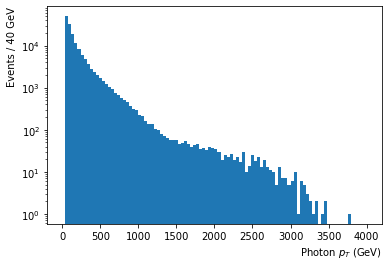

In [12]:
n_bins_pt = 100;
#(max(df['Photon_pt'])-min(df['Photon_pt']))/60
#bins=np.arange(min(data), max(data) + binwidth, binwidth)
df['Photon_pt'].plot.hist(bins=n_bins_pt,range=(0,4000),log=True); #weights=df['Event_weightAll']
plt.xlabel('Photon $p_T$ (GeV)', horizontalalignment='right', x=1.0);
plt.ylabel('Events / '+str(int(4000/n_bins_pt))+' GeV', horizontalalignment='right', y=1.0);

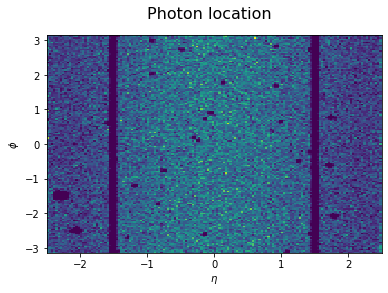

In [13]:
#df.plot.scatter('Photon_scEta', 'Photon_scPhi');
plt.hist2d(df['Photon_scEta'],df['Photon_scPhi'],bins=150); #weights=df['Event_weightAll']
plt.suptitle('Photon location',fontsize=16)
plt.xlabel('$\eta$');
plt.ylabel('$\phi$');

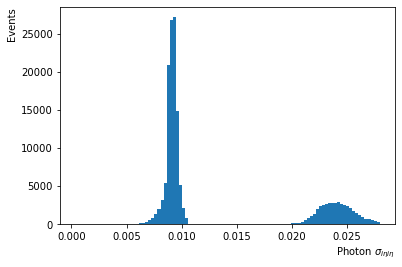

In [14]:
df['Photon_sigmaIetaIeta5x5'].plot.hist(bins=100,log=False); #weights=df['Event_weightAll']
plt.xlabel('Photon $\sigma_{i\eta i\eta}$', horizontalalignment='right', x=1.0);
plt.ylabel('Events', horizontalalignment='right', y=1.0);

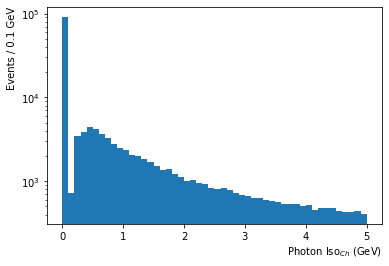

In [15]:
df['Photon_chargedHadIso03'].plot.hist(bins=50,log=True); #weights=df['Event_weightAll']
plt.xlabel('Photon Iso$_{Ch}$ (GeV)', horizontalalignment='right', x=1.0);
plt.ylabel('Events / '+str(5/50)+' GeV', horizontalalignment='right', y=1.0);

## Create labels

Let's encode the fake criteria into a single label:
- Real photons ($y=0$)
- Fake photons ($y=1$)

Store this as a NumPy array `Y_train`.

In [7]:
def is_fake(row):
    if (row['Photon_passHighPtID'] == 1) and ((row['PhotonGenMatch_matchCategory'] == 1) or (row['PhotonGenMatch_matchCategory'] == 2)) and (row['PhotonGenMatch_matchType'] == 1):
        val = 1
    else:
        val = 0
    return val    

In [8]:
df['fake'] = df.apply(is_fake, axis=1)

In [18]:
#df[['PhotonGenMatch_matchCategory','PhotonGenMatch_matchType','fake']][df['fake']==1]
df['fake'].value_counts()

0    138435
1     17767
Name: fake, dtype: int64

In [9]:
Y = df['fake'].to_numpy()
Y.shape
#Y_train = Y.reshape(Y.shape[0],1)
#Y_train.shape

(156202,)

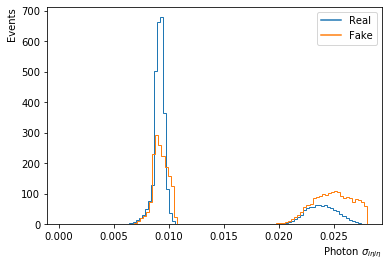

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
df['Photon_sigmaIetaIeta5x5'][df['fake']==0].plot.hist(bins=100,density=True,log=False,label='Real',histtype='step'); # weights=df['Event_weightAll'][df['fake']==0]
df['Photon_sigmaIetaIeta5x5'][df['fake']==1].plot.hist(bins=100,density=True,log=False,label='Fake',histtype='step'); # weights=df['Event_weightAll'][df['fake']==1]
plt.xlabel('Photon $\sigma_{i\eta i\eta}$', horizontalalignment='right', x=1.0);
plt.ylabel('Events', horizontalalignment='right', y=1.0);
plt.legend(loc='upper right');
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.show()

## Prepare features

Organize desired features into NumPy array `X_train`. Normalize features by mean and standardize by the standard deviation.


In [10]:
features = ['Photon_pt','Photon_eta','Photon_phi','Photon_iEta','Photon_iPhi','Photon_rho','Photon_chargedHadIso03','Photon_neutralHadIso03','Photon_photonIso03','Photon_hadTowerOverEm','Photon_r9_5x5','Photon_sigmaIetaIeta5x5','Photon_sigmaIphiIphi5x5','Photon_sigmaIetaIphi5x5','Photon_maxEnergyXtal']
X = df[features].to_numpy()

In [22]:
X.shape

(156202, 15)

In [11]:
scaler = preprocessing.StandardScaler().fit(X)

In [12]:
X_scaled = scaler.transform(X)

In [13]:
X_scaled.shape

(156202, 15)

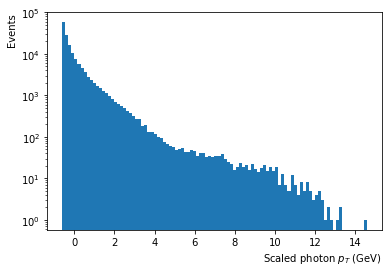

In [26]:
plt.hist(x=X_scaled[:,0], bins=100,log=True);
plt.xlabel('Scaled photon $p_T$ (GeV)', horizontalalignment='right', x=1.0);
plt.ylabel('Events', horizontalalignment='right', y=1.0);

## Feature Correlation

- The strongest correlations are among the angular coordinates, shower shapes along the angular coordinates, and among the different energy variables

In [27]:
corr = df[features].corr()

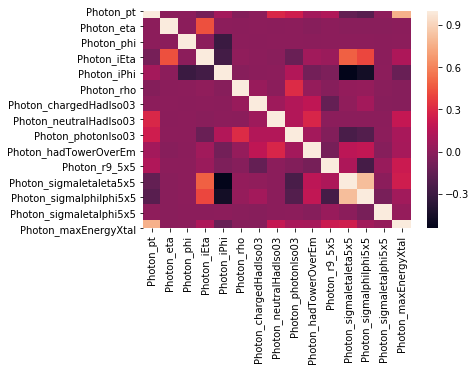

In [28]:
sns.heatmap(corr);

## Split dataset

Let's divided the dataset into training and testing datasets.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3)

In [15]:
print ("Number of total examples: " + str(X.shape[0]))
print ("Number of training examples: " + str(X_train.shape[0]))
print ("Number of testing examples: " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of total examples: 156202
Number of training examples: 109341
Number of testing examples: 46861
X_train shape: (109341, 15)
Y_train shape: (109341,)
X_test shape: (46861, 15)
Y_test shape: (46861,)


## Simple Logistic Regression Classifier

We train a simple linear classifier using logistic regression to get a baseline for performance on this dataset.

In [31]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X_train, Y_train);

/Users/abuccilli/anaconda3/envs/photon-classification-keras/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [32]:
LR_predictions_train = clf.predict(X_train)
print ('Accuracy of logistic regression: %d' % float((np.dot(Y_train,LR_predictions_train) + np.dot(1-Y_train,1-LR_predictions_train))/float(Y_train.size)*100) +'% ' + "(training set)")

Accuracy of logistic regression: 92% (training set)


In [33]:
LR_predictions_test = clf.predict(X_test)
print ('Accuracy of logistic regression: %d' % float((np.dot(Y_test,LR_predictions_test) + np.dot(1-Y_test,1-LR_predictions_test))/float(Y_test.size)*100) +'% ' + "(test set)")

Accuracy of logistic regression: 92% (test set)


- The accuracy is promising; however, the classes are skewed so let's check the F1 score.

In [34]:
sklearn.metrics.f1_score(Y_test, LR_predictions_test)

0.6007259528130672

In [35]:
np.dot(Y_test,LR_predictions_test)/sum(Y_test==1)*100.

49.38455800074599

In [36]:
np.dot(1-Y_test,1-LR_predictions_test)/sum(Y_test==0)*100.

98.05778452492831

## Nonlinear classifier

We use a 4-layer deep neural network as our classifier, comprising 3 hidden layers. L2 regularization is used.

In [23]:
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(10,10,4), max_iter=1500, learning_rate_init=0.0001, random_state=1)
clf_NN.fit(X_train,Y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 4), learning_rate='constant',
              learning_rate_init=0.0001, max_iter=1500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [24]:
NN_predictions_train = clf_NN.predict(X_train)
print ('Accuracy of NN: %d' % float((np.dot(Y_train,NN_predictions_train) + np.dot(1-Y_train,1-NN_predictions_train))/float(Y_train.size)*100) +'% ' + "(training set)")

Accuracy of NN: 94% (training set)


In [25]:
NN_predictions_test = clf_NN.predict(X_test)
print ('Accuracy of NN: %d' % float((np.dot(Y_test,NN_predictions_test) + np.dot(1-Y_test,1-NN_predictions_test))/float(Y_test.size)*100) +'% ' + "(test set)")

Accuracy of NN: 94% (test set)


In [26]:
sklearn.metrics.f1_score(Y_test, NN_predictions_test)

0.7210164107993646

In [27]:
np.dot(Y_test,NN_predictions_test)/sum(Y_test==1)*100.

64.08808582721626

In [28]:
np.dot(1-Y_test,1-NN_predictions_test)/sum(Y_test==0)*100.

98.250216616925

# DNN with Keras

In [43]:
classifier = Sequential()
classifier.add(Dense(10, activation='relu', kernel_initializer='normal', input_dim=len(features)))
classifier.add(Dense(10, activation='relu', kernel_initializer='normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

Instructions for updating:
Colocations handled automatically by placer.


In [44]:
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
classifier.fit(X_train,Y_train, batch_size=100, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
109341/109341 [==============================] - 2s 15us/step - loss: 0.2657 - acc: 0.8882
Epoch 2/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.2048 - acc: 0.9288
Epoch 3/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1960 - acc: 0.9319
Epoch 4/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1904 - acc: 0.9326
Epoch 5/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1872 - acc: 0.9332
Epoch 6/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1845 - acc: 0.9342
Epoch 7/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1823 - acc: 0.9340
Epoch 8/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1808 - acc: 0.9345
Epoch 9/10
109341/109341 [==============================] - 1s 11us/step - loss: 0.1795 - acc: 0.9348
Epoch 10/10
109341/109341 [=======

2019-07-09 15:44:41.187146: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [45]:
classifier.evaluate(X_train, Y_train)

109341/109341 [==============================] - 1s 10us/step


[0.17754322619894813, 0.9353947741529312]

In [53]:
Y_pred_keras = classifier.predict(X_test)

In [54]:
Y_pred_keras = (Y_pred_keras > 0.5)

In [55]:
print ('Accuracy of NN: %d' % float((np.dot(Y_test,Y_pred_keras) + np.dot(1-Y_test,1-Y_pred_keras))/float(Y_test.size)*100) +'% ' + "(test set)")

Accuracy of NN: 93% (test set)


In [56]:
sklearn.metrics.f1_score(Y_test, Y_pred_keras)

0.6720395443799699

In [57]:
np.squeeze(np.dot(Y_test,Y_pred_keras)/sum(Y_test==1))*100.

58.317791868705704

In [58]:
np.squeeze(np.dot(1-Y_test,1-Y_pred_keras)/sum(Y_test==0))*100.

98.03127786211716

# Test on Production Data

We further check our classifier's performance by checking it on other data. First, we need to preprocess our features. This dataset is heavily skewed between classes.

In [16]:
df_test = read_root(fGJets2,'diphoton/fTreeFake',columns=['Photon','PhotonGenMatch','Event'])

In [17]:
df_test = df_test[df_test['Photon_passHighPtID'] == 1]
df_test = df_test[(df_test['Photon_isEB']==True) | (df_test['Photon_isEE']==True)]
df_test = df_test[(df_test['Photon_pt'] > 50.0) & (df_test['Photon_sigmaIphiIphi5x5'] > 0.009)]
len(df_test)

1869221

In [18]:
df_test['fake'] = df_test.apply(is_fake, axis=1)

In [19]:
df_test['fake'].value_counts()

0    1862201
1       7020
Name: fake, dtype: int64

In [20]:
Y_prod = df_test['fake'].to_numpy()
X_prod = df_test[features].to_numpy()

In [21]:
X_prod_scaled = scaler.transform(X_prod)

In [29]:
NN_predictions_prod = clf_NN.predict(X_prod_scaled)
print ('Accuracy of NN: %d' % float((np.dot(Y_prod,NN_predictions_prod) + np.dot(1-Y_prod,1-NN_predictions_prod))/float(Y_prod.size)*100) +'% ' + "(production test set)")

Accuracy of NN: 97% (production test set)


In [30]:
sklearn.metrics.f1_score(Y_prod, NN_predictions_prod)

0.15303292571705104

In [31]:
np.dot(Y_prod,NN_predictions_prod)/sum(Y_prod==1)*100.

58.56125356125356

In [32]:
np.dot(1-Y_prod,1-NN_predictions_prod)/sum(Y_prod==0)*100.

97.71259923069529